In [1]:
import torch
import os
import tqdm
import Model
import Utils
import Loss
import Deeplearning
import torch.nn             as nn
import matplotlib.pyplot    as plt
import numpy                as np
import torch.optim          as optim

Utils.set_seed(42)
device = 'cuda'

In [2]:
prediction_horizon      = Utils.prediction_horizon
prediction_input_size   = Utils.prediction_input_size
epochs                  = Utils.num_epochs
_divition_factr         = Utils.Noise_division_factor

model     = Model.Encoder_Decoder(prediction_input_size).to(device)
criterion = Loss.custum_loss(alpha=Utils.alpha)#torch.nn.MSELoss()
optimizer = optim.SGD(
                        model.parameters(),
                        lr=5e-2,
                        momentum=0.9,
                        weight_decay=1e-4
                        )



optimizer_koopman = optim.SGD(
                        model.Koopman_operator.parameters(),
                        lr=5e-4,
                        # momentum=0.9,
                        # weight_decay=1e-4
                        )

with Koopman Horizion = 10  1499/1499 [15:23<00:00,  1.62it/s, avg_train_loss_till_current_batch=0.1599, loss_batch=0.4948] 1/1 

with out Koopman            1499/1499 [10:52<00:00,  2.30it/s, avg_train_loss_till_current_batch=0.1600, loss_batch=0.4536] 1/1 

In [3]:
npz_file_path = "Duffing_Soulution\datasets\gamma=0.37 t_span=(0, 100000) initial_conditions=[1.5, -1.5].npy"
loaded_data = Utils.read_npz_file(npz_file_path)
data_tensor = torch.from_numpy(loaded_data).to(device=device).to(torch.float)

_Model_name = f"Gamma ={npz_file_path.split(' ')[0].split('=')[-1]} {prediction_input_size=} cu_loss={Utils.Eigen} init=({npz_file_path.split('[')[-1].split(']')[0]}) noise_factor={_divition_factr} gammas=0.37-0.29"

model, optimizer, report = Deeplearning.train(
                                                data_tensor                 = data_tensor[0:100_000],
                                                prediction_input_size       = prediction_input_size,
                                                prediction_horizon          = Utils.prediction_horizon,
                                                _divition_factr             = _divition_factr,
                                                
                                                model                       = model,
                                                model_name                  = _Model_name ,
                                                epochs                      = 1,#epochs,
                                                load_saved_model            = False,
                                                ckpt_save_freq              = 1 ,
                                                ckpt_save_path              = os.path.join("Saved" ,".Checkpoints"),
                                                ckpt_path                   = os.path.join("Saved" ,".Checkpoints","ckpt_Gamma =0.50 prediction_input_size=200 cu_loss=False init=(1, 0) noise_factor=1 gammas=0.37-0.29_epoch1.ckpt") ,
                                                report_path                 = "Saved" ,
                                                
                                                criterion                   = criterion,
                                                optimizer                   = optimizer,
                                                optimizer_koopman           = optimizer_koopman,
                                                lr_scheduler                = None,
                                                sleep_time                  = None,
                                                Validation_save_threshold   = None,
                                                device                      = 'cuda'    ,
                                                )

train:   0%|          | 0/499 [00:00<?, ?it/s]

100%|██████████| 1/1 [04:25<00:00, 265.86s/it]


***
TODO
***

for matrix production use a list to dont calculate the power of calculate matrices 
    soul : by not using power i forced to detach previous matrices
***
***
***

# ChangeLog

1.  waiting to solution settle
2.  using only th acceleration data instead of the v and x
3.  

# Note
1.  try to remove the drop out in LSTM

2.  BE SURE data for chaotic case in Clean. (Training)
3.  Be sure for integration data is noise free.(Integrating)

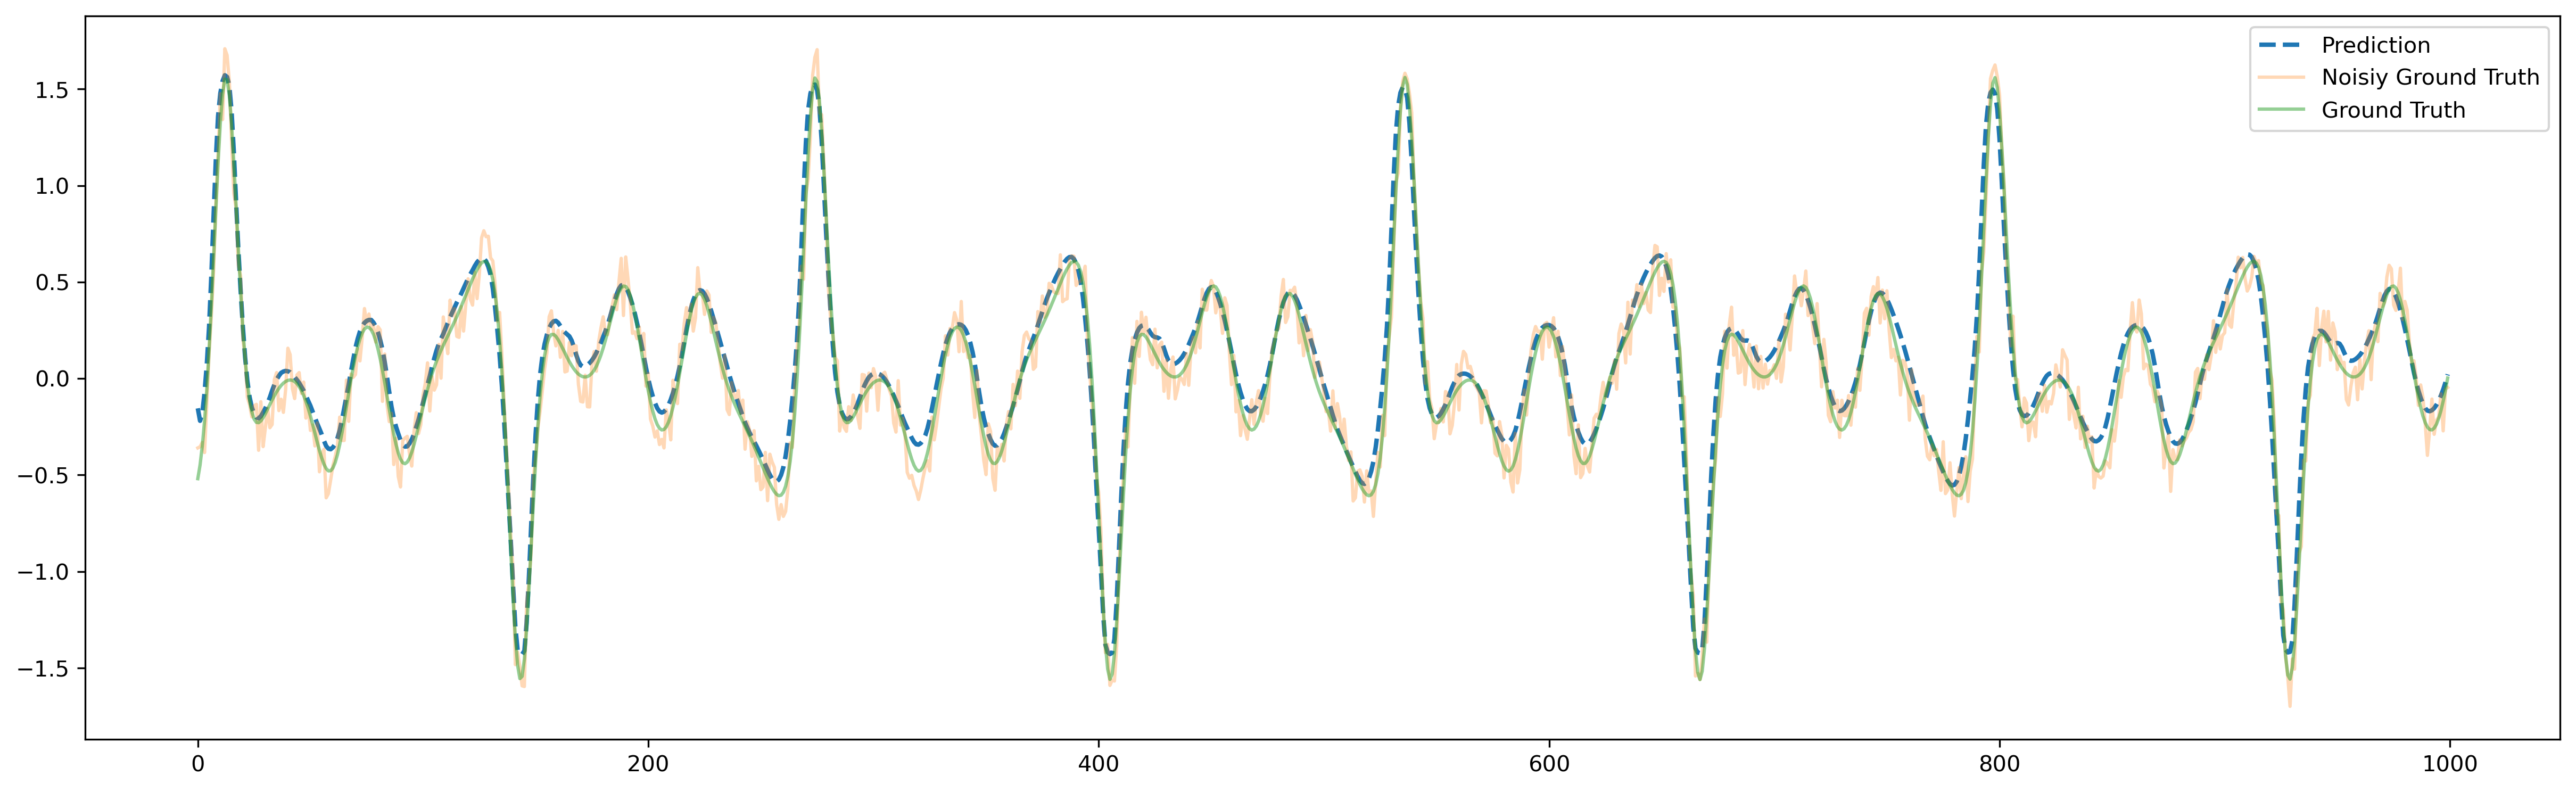

In [12]:
# npz_file_path = "Duffing_Soulution\datasets\gamma=0.37 t_span=(0, 100000) initial_conditions=[0, 0.5].npy"
# loaded_data = Utils.read_npz_file(npz_file_path)
# data_tensor = torch.from_numpy(loaded_data).to(device=device).to(torch.float)

# model.load_state_dict(torch.load(os.path.join(directory_path)))
# model.eval()


_divition_factr = 3

with torch.inference_mode():
    Batch = 10
    pred_hor = 1000
    x = data_tensor[Batch*prediction_input_size:(Batch+1)*prediction_input_size]+((2*torch.rand(size=[prediction_input_size],device=device)-1)/(2*_divition_factr))
    y = data_tensor[(Batch+1)*prediction_input_size:(Batch+1)*prediction_input_size+pred_hor]

    prediction_list = torch.zeros(size=[pred_hor]).to(device)

    decoder_hidden, decoder_cell = torch.zeros(size=[2,prediction_input_size],device=device), torch.zeros(size=[2,prediction_input_size],device=device)
    for i in range(pred_hor):
        # prediction = inception.forward(x)
        prediction,(decoder_hidden, decoder_cell) = model.forward(x.unsqueeze(0),decoder_hidden, decoder_cell)
        x =  torch.cat([x[1:],prediction],dim=0)
        prediction_list[i] = prediction


plt.figure(figsize=(20, 6),dpi=300)
plt.plot((prediction_list[:]                                             ).detach().cpu().numpy() , linewidth=2,linestyle='dashed', label="Prediction")
plt.plot((y[:]+(2*torch.rand(size=[pred_hor],device=device)-1)/(2*_divition_factr) ).detach().cpu().numpy() , alpha=0.3, label="Noisiy Ground Truth")
plt.plot((y[:]                                                           ).detach().cpu().numpy() , alpha=0.5, label="Ground Truth")
plt.legend()

In [40]:
_prediction_list = []
_y               = []

_divition_factr         = Utils.Noise_division_factor

for adress     in [ 'Duffing_Soulution\datasets\gamma=0.37 t_span=(0, 100000) initial_conditions=[1.5, -1.5].npy',
                    'Duffing_Soulution\datasets\gamma=0.20 t_span=(0, 100000) initial_conditions=[1, 0].npy',
                    'Duffing_Soulution\datasets\gamma=0.29 t_span=(0, 100000) initial_conditions=[1, 0].npy',
                        ]:
# for _divition_factr in [2,0.5,7]:
    loaded_data = Utils.read_npz_file(adress)
    data_tensor = torch.from_numpy(loaded_data).to(device=device).to(torch.float)
    with torch.inference_mode():
        Batch = 10
        pred_hor = 500
        x = data_tensor[Batch*prediction_input_size:(Batch+1)*prediction_input_size]+((2*torch.rand(size=[prediction_input_size],device=device)-1)/(2*_divition_factr))
        y = data_tensor[(Batch+1)*prediction_input_size:(Batch+1)*prediction_input_size+pred_hor]

        prediction_list = torch.zeros(size=[pred_hor]).to(device)

        decoder_hidden, decoder_cell = torch.zeros(size=[2,prediction_input_size],device=device), torch.zeros(size=[2,prediction_input_size],device=device)
        for i in range(pred_hor):
            # prediction = inception.forward(x)
            prediction,(decoder_hidden, decoder_cell) = model.forward(x.unsqueeze(0),decoder_hidden, decoder_cell)
            x =  torch.cat([x[1:],prediction],dim=0)
            prediction_list[i] = prediction

    _prediction_list.append(prediction_list)
    _y.append(y)

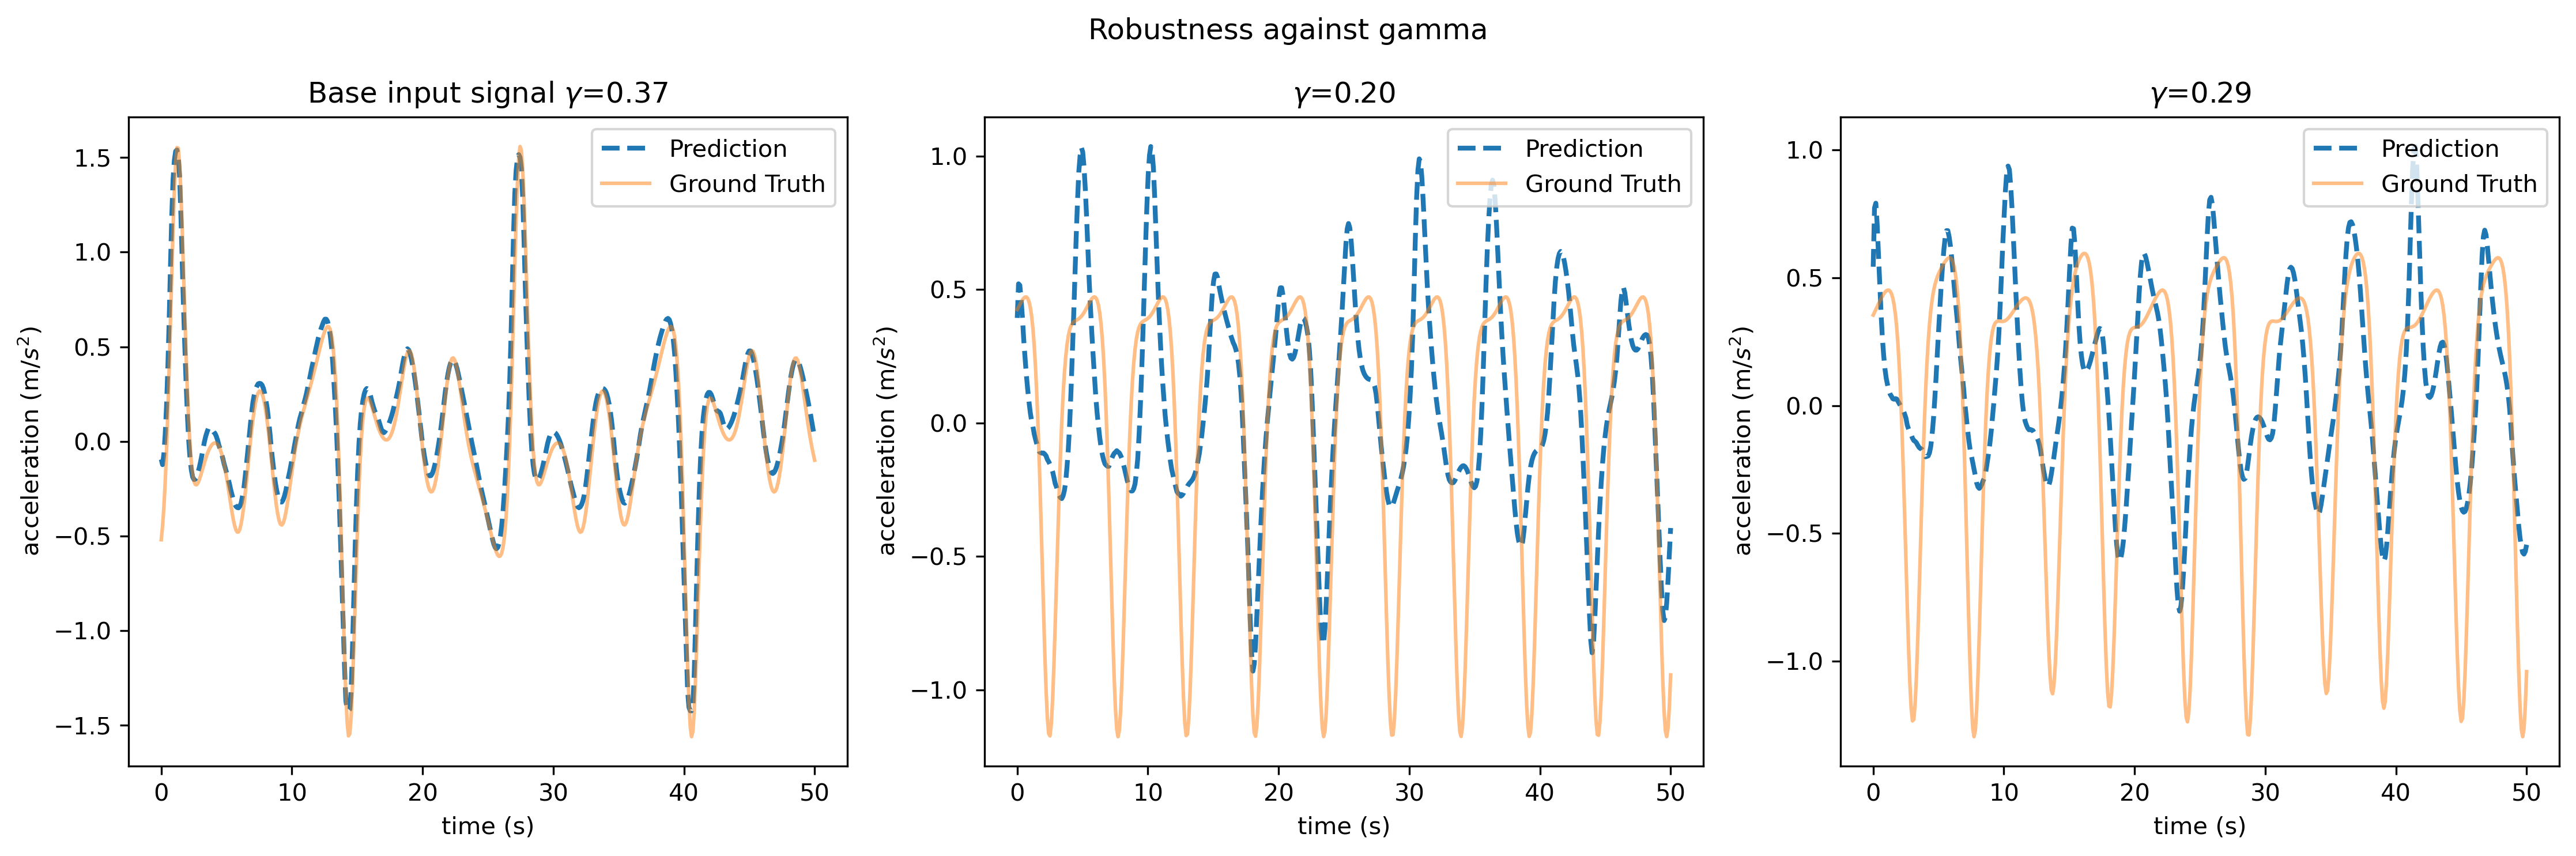

In [42]:
import matplotlib.pyplot as plt

def plot_signals(_prediction_list,_y, legends, descriptions,title,_divition_factr=_divition_factr):
    """
    Create three subplots with signals, legends, descriptions, and axis labels.
    Parameters:
    signals (list of arrays): List of signal arrays to be plotted.
    legends (list of str): List of legend labels for each signal.
    descriptions (list of str): List of descriptions for each signal.
    x_label (str): Label for the x-axis.
    y_label (str): Label for the y-axis.
    title (str): Title for the entire plot.
    """
    t = np.linspace(0, len(_y[0])/10, len(_y[0]))

    num_signals = len(signals)
    if num_signals != 3:
        raise ValueError("Exactly three signals are required.")
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5),dpi=300)
    for i, ax in enumerate(axes):

        ax.plot(t,(_prediction_list[i]).detach().cpu().numpy() , linewidth=2,linestyle='dashed', label="Prediction")
        # ax.plot(t,(_y[i]+(2*torch.rand(size=[pred_hor],device=device)-1)/(2*_divition_factr) ).detach().cpu().numpy() , alpha=0.3, label="Noisiy Ground Truth")
        ax.plot(t,(_y[i]).detach().cpu().numpy() , alpha=0.5, label="Ground Truth")
        ax.set_xlabel('time (s)')
        ax.set_ylabel('acceleration (m/$s^2$)')
        ax.set_title(descriptions[i])
        ax.legend(loc='upper right')
    plt.suptitle(title)
    plt.tight_layout()

    plt.savefig(f"{title}.jpg")
    plt.show()


descriptions = ["Base input signal $\gamma$=0.37", "$\gamma$=0.20", "$\gamma$=0.29"]
x_label = "Time"
y_label = "Amplitude"
title   = "Robustness against gamma"

plot_signals(_prediction_list,_y, legends, descriptions, title)


# Noise

In [ ]:
import matplotlib.pyplot as plt

def plot_signals(_prediction_list,_y, legends, descriptions,title,_divition_factr=_divition_factr):
    """
    Create three subplots with signals, legends, descriptions, and axis labels.
    Parameters:
    signals (list of arrays): List of signal arrays to be plotted.
    legends (list of str): List of legend labels for each signal.
    descriptions (list of str): List of descriptions for each signal.
    x_label (str): Label for the x-axis.
    y_label (str): Label for the y-axis.
    title (str): Title for the entire plot.
    """
    t = np.linspace(0, len(_y[0])/10, len(_y[0]))

    num_signals = len(signals)
    if num_signals != 3:
        raise ValueError("Exactly three signals are required.")
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5),dpi=300)
    for i, ax in enumerate(axes):

        ax.plot(t,(_prediction_list[i]).detach().cpu().numpy() , linewidth=2,linestyle='dashed', label="Prediction")
        # ax.plot(t,(_y[i]+(2*torch.rand(size=[pred_hor],device=device)-1)/(2*_divition_factr) ).detach().cpu().numpy() , alpha=0.3, label="Noisiy Ground Truth")
        ax.plot(t,(_y[i]).detach().cpu().numpy() , alpha=0.5, label="Ground Truth")
        ax.set_xlabel('time (s)')
        ax.set_ylabel('acceleration (m/$s^2$)')
        ax.set_title(descriptions[i])
        ax.legend(loc='upper right')
    plt.suptitle(title)
    plt.tight_layout()

    plt.savefig(f"{title}.jpg")
    plt.show()


descriptions = ["Base input signal Noise range = (-0.5,0.5)", "Noise range = (-1,1)", "Noise range = (-0.07,0.07)"]
x_label = "Time"
y_label = "Amplitude"
title   = "Robustness against Noises"

plot_signals(_prediction_list,_y, legends, descriptions, title)


In [52]:
eigenvalues, eigenvectors = torch.linalg.eig(model.Koopman_operator.weight)

real_parts = torch.real(eigenvalues)
imaginary_parts = torch.imag(eigenvalues)
magnitudes = torch.abs(real_parts + 1j * imaginary_parts)

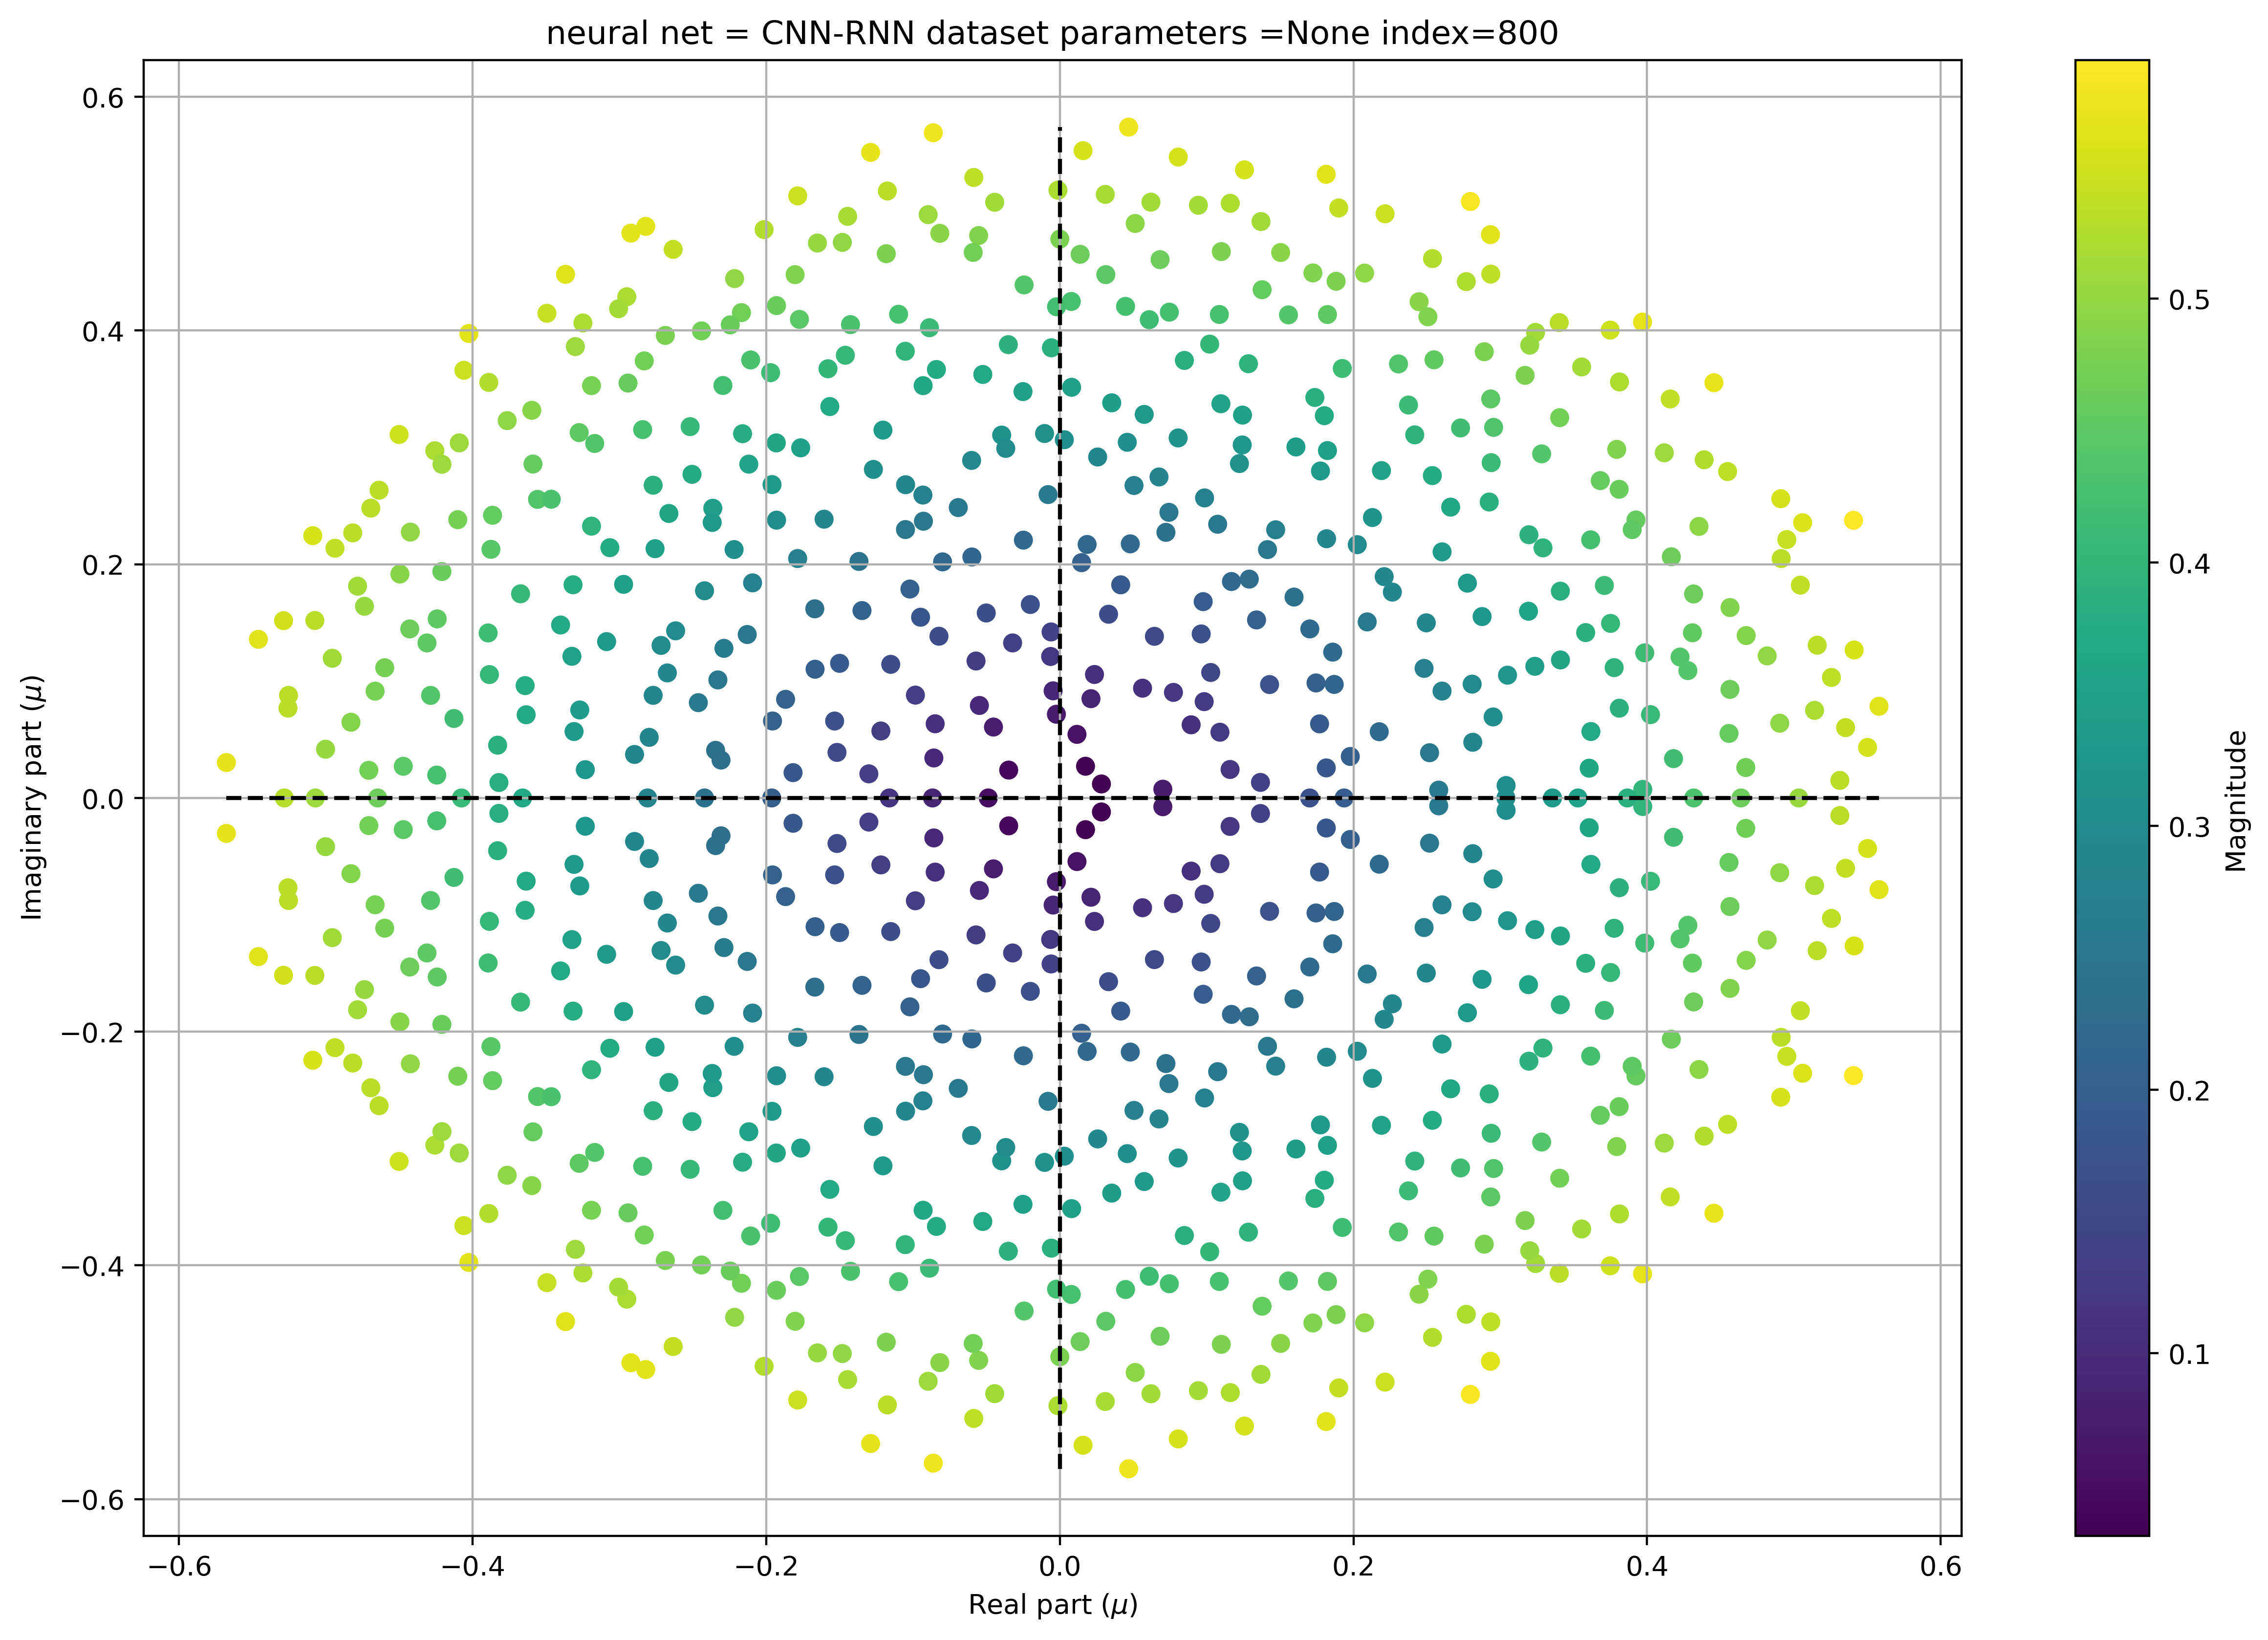

In [55]:
Utils.Koopman_Eigenvalue(real_parts.detach(),
                         imaginary_parts.detach(),
                         magnitudes.detach(),
                         _index         = 800,
                        DPI             = 400,
                        save_image      = True,
                        neural_net_name = "CNN-RNN",
                        save_dir = '.')